# Short introduction to tensorflow

[Tensorflow](https://www.tensorflow.org/) is the machine learning library of google that mostly concentrates on neural networks. It may be run across  multiple devices and supports graphics card acceleration. There are a ton of more features, and you could use it (and it is used) in a professional setting. Let me demonstrate it with a very basic example.

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-v0_8")
print("Tensorflow version: "+tf.version.VERSION)

Tensorflow version: 2.11.0


We load the fashion-MNIST dataset, a dataset of the same form and format as MNIST, only instead of handwritten digits it shows different types of clothing. The aim consists in identifying the type of clothing (shoe, T-shirt etc). See https://github.com/zalandoresearch/fashion-mnist

In [2]:
fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # normalise so that all values in [0,1]

In [3]:
len(y_train), len(y_test)

(60000, 10000)

Let's have a look at a random datapoint:

(-0.5, 27.5, 27.5, -0.5)

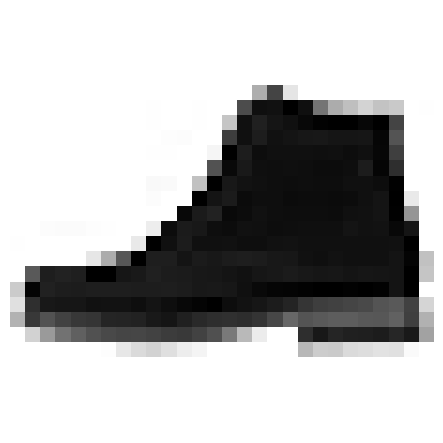

In [16]:
_,ax=plt.subplots()
ax.imshow(x_train[42],cmap='binary')
ax.axis('off')

It's a shoe!

We now define our neural network. It will be very simply: it will have an input, a hidden layer with ReLU activation and an output layer with softmax activation. tf.keras is a sublibrary of tensorflow that is designed to be easy to use. We pick a <code>Sequential</code> model of a neural network: that simply means we'll have one layer after another. The input layer is a <code>Flatten</code> layer that transforms the 28x28 pictures into a vector (of length $28\cdot 28$). The hidden layer is a <code>Dense</code> layer, that is, a fully connected layers. We specify it to have 128 neurons. Finally, the output layer is also dense, ie, fully connected.

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax') # 10 neurons as we have 10 classes
])

2023-11-13 11:22:33.985403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 11:22:33.986161: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Note that the finally layer has softmax <code>activation</code>. Thus, each prediction gives a probability distribution over the classes. 

When training a neural network we do not directly minimise the zero-one loss. Zero-one loss is not continuous and generally not easy to handle during learning. Instead, as in logistic regression, we're working with a surrogate loss function. Here, we pick cross entropy, and more specifically *categorical cross entropy*. What is that? 

*Categorical cross entropy* is used for multi-class predictions. Each prediction $y$ is assumed to give a probability distribution over the classes. That is, $y\in[0,1]^d$ and $\sum_{j=1}^dy_j=1$. A typical prediction would be $24\%$ cat, $62\%$ dog and $14\%$ gerbil. The true classes $y^*$ are assumed to be *one-hot* encoded, ie, each $y^*$ is a unit vector in $\mathbb R^d$. Then the *categorical cross entropy* is 

$$\text{loss}(y^*,y) = \sum_{j=1}^d y^*_{j}\ln(y_{j})$$

This is then averaged over the whole test or training set. 

Often the true classes are encoded in a more economical way, namely as integers. Ie, $y^*=3$ may mean *cat* and $y^*=6$ means *capybara*. Tensorflow offers a method called <code>SparseCategoricalCrossentropy</code> that computes the loss from classes in integer encoding as if they were one-hot encoded. (If, in your training set, the classes are already one-hot encoded, use <code>CategoricalCrossentropy</code> instead.)

In [6]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()

Before we fit, we need to connect the model with the loss function, which we do by calling <code>compile</code>. While we're at it, we also specify that, during training, we'd like to get some information on the training error. Or rather, instead of how the fraction of misclassified samples in the training, we request what fraction is correctly classified (*accuracy*).

In [7]:
model.compile(loss=loss_fn, metrics=['accuracy'])

It's time to train the neural network. We specify the number of <code>epochs</code> of training. An epoch is one complete turn through the training data. After a while, a number of epochs, we'll see that the training error (or rather the accuracy) does not decrease anymore. It makes no sense to train beyond that point, and in fact, it may be good to stop long before that. Training for too many epochs may reduce the training error, but at the same time test error may increase again at some point. 

(Next cell may take a while.)

In [8]:
history=model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.5033 - accuracy: 0.8224
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3729 - accuracy: 0.8656
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3426 - accuracy: 0.8775
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3249 - accuracy: 0.8834
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3115 - accuracy: 0.8890
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3020 - accuracy: 0.8927
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2936 - accuracy: 0.8963
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2857 - accuracy: 0.9003
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2794 - accuracy: 0.9013
Epoch 10/10
1875/1875 [==============================] - 22s 12ms/ste

What are these *epochs*? Those are complete runs through the training set. We'll see soon what is happening here.

We evaluate now on the test set, ie, compute the test error.

In [9]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3906 - accuracy: 0.8774 - 751ms/epoch - 2ms/step


[0.39063286781311035, 0.8773999810218811]

Finally, let's look how to do a prediction. Predictions are normally done for a whole *batch* of samples at once. If we want a single prediction, we need to make sure that the input is still a list of samples -- even if the list has only a single entry.

In [18]:
which_one=42
predictions=model.predict(x_train[which_one:which_one+1])
predictions

1/1 [==============================] - 0s 35ms/step


array([[4.19418994e-15, 1.16835168e-14, 9.63607858e-22, 3.32065763e-18,
        1.15315626e-20, 3.53826457e-09, 6.23501208e-23, 2.51876470e-03,
        2.58118722e-15, 9.97481287e-01]], dtype=float32)

These numbers are a bit hard to read. Let's write this in a nicer way:

In [11]:
class_names=["T-shirt/top","Trousers","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
for c,p in zip(class_names,predictions[0]):
    print("{:11}:{:6.2f}%".format(c,p*100))

T-shirt/top:  0.00%
Trousers   :  0.00%
Pullover   :  0.00%
Dress      :  0.00%
Coat       :  0.00%
Sandal     :  0.00%
Shirt      :  0.00%
Sneaker    :  0.25%
Bag        :  0.00%
Ankle boot : 99.75%


Finally, when training above we had captured the result of training in a variable called <code>history</code>. Let's see what we can do with it. 

First it contains the loss and all metrics we had computed during training:

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

The object also remembers the epochs:

In [14]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Let's plot training loss (ie, cross entropy) by epoch.

Text(0, 0.5, 'training accuracy [%]')

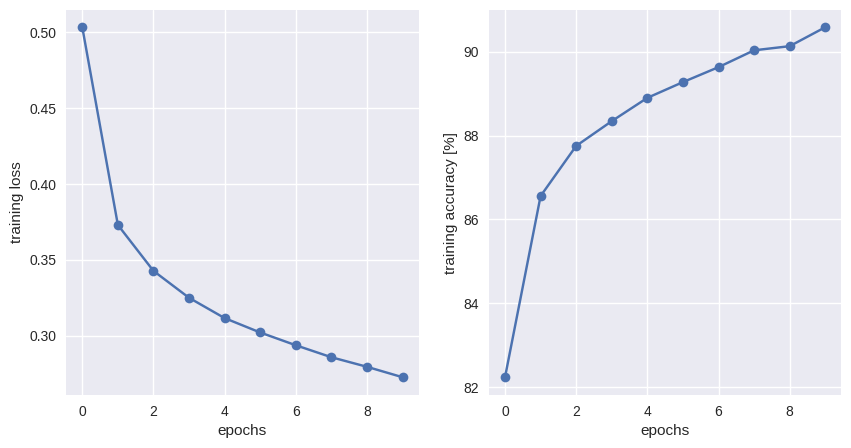

In [22]:
_,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(history.epoch,history.history['loss'],'o-')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('training loss')

axs[1].plot(history.epoch,np.array(history.history['accuracy'])*100,'o-')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('training accuracy [%]')

What we can see: Training error could probably improve with more epochs. (Best, however, would be to also track a validation error during training.) This is easily accomplished. We could train the model a bit more as follows:

<code>history2=model.fit(x_train, y_train, epochs=5)</code>